# # Classifiers comparison on texts with naive Bayes assumption

In this session of laboratory we compare two models for categorical data probabilistic modeling: 
1. multivariate Bernoulli 
2. multinomial on a dataset 

We adopt a dataset on Twitter messages labelled with emotions (Joy vs Sadness).

The following program shows the loading of the data from a file.

Data are loaded into a matrix X adopting a sparse matrix representation, in order to save space and time.
Sparse matrix representation (in the csr format) represents in three "parallel" arrays the value of the matrix cells that are different from zero and the indices of those matrix cells.
The arrays are called: 
- data
- row
- col

- data[i] stores the value of the matrix cell #i whose indexes are contained in row[i] and col[i] 
- row[i] stores the index of the row in the matrix of the cell #i, 
- col[i] stores the index of the column of the cell #i.


The data file is in csv format.
Any Twitter message has been preprocessed by a Natural Language pipeline which eliminated stop words and substituted the interesting document elements with an integer identifier.  
The interesting document elements might be words, emoji or emoticons. The elements could be repeated in the same document and are uniquely identified in the documents by the same integer number (named "element_id" in the program). This "element_id" number will be used as the index of the column of the data matrix, for the purposes of storage of data.

Each row of the CSV file reports the content of a document (a Twitter message).It is formed as a list of integer number pairs, followed by a string which is the label of the document ("Joy" or "Sadness").
The first number of the pair is the identifier of a document element (the "element_id"); 
the second number of the pair is the count (frequency) of that element in that document.

The dataset has:

tot_n_docs (or rows in the file) =n_rows=11981

n_features (total number of distinct words in the corpus)=11288



The following program reads the data file and loads in a sparse way the matrix using the scipy.sparse library

In [118]:

from numpy import ndarray, zeros
import numpy as np
import scipy
from scipy.sparse import csr_matrix

class_labels = ["Joy","Sadness"]
n_features=11288 # number of columns in the matrix = number of features (distinct elements in the documents)
n_rows=11981 # number rows of the matrix
n_elements=71474 # number of the existing values in the matrix (not empty, to be loaded in the matrix in a sparse way)

#path_training="/Users/meo/Documents/Didattica/Laboratorio-15-16-Jupyter/"
path_training="../../Datasets/"
file_name="joy_sadness6000.txt"

# declare the row and col arrays with the indexes of the matrix cells (non empty) to be loaded from file
# they are needed because the matrix is sparse and we load in the matrix only the elements which are present
row=np.empty(n_elements, dtype=int)
col=np.empty(n_elements, dtype=int)
data=np.empty(n_elements, dtype=int)

row_n=0 # number of current row to be read and managed
cur_el=0 # position in the three arrays: row, col and data
twitter_labels=[] # list of class labels (target array) of the documents (twitter) that will be read from the input file
twitter_target=[] # list of 0/1 for class labels
with open(path_training + file_name, "r") as fi:
    for line in fi:
        el_list=line.split(',')  # list of integers read from a row of the file
        l=len(el_list)
        last_el=el_list[l-1] # I grab the last element in the list which is the class label
        class_name=last_el.strip() # eliminate the '\n'
        twitter_labels.append(class_name)
        # twitter_labels contains the labels (Joy/Sadness); twitter_target contains 0/1 for the respective labels
        if (class_name==class_labels[0]):
           twitter_target.append(0)
        else:
           twitter_target.append(1)
        i=0 # I start reading all the doc elements from the beginning of the list
        while(i<(l-1)):
            element_id=int(el_list[i]) # identifier of the element in the document equivalent to the column index
            element_id=element_id-1 # the index starts from 0 (the read id starts from 1)
            i=i+1
            value_cell=int(el_list[i]) # make access to the following value in the file which is the count of the element in the documento 
            i=i+1
            row[cur_el]=row_n # load the data in the three arrays: the first two are the row and col indexes; the last one is the matrix cell value
            col[cur_el]=element_id
            data[cur_el]=value_cell
            cur_el=cur_el+1
        row_n=row_n+1
fi.close
print("final n_row="+str(row))
# loads the matrix by means of the indexes and the values in the three arrays just filled
twitter_data=csr_matrix((data, (row, col)), shape=(n_rows, n_features)).toarray()
# print("resulting matrix:")
# print(twitter_data)
# print(twitter_labels)
# print(twitter_target)

print(twitter_data.shape)
twitter_target = (np.array(twitter_target))
print(twitter_target.shape)

final n_row=[0 0 0 ... 0 0 0]
(11981, 11288)
(11981,)


Write a program in the following cell that splits the data matrix in training and test set (by random selection) and predicts the class (Joy/Sadness) of the messages on the basis of the words. 
Consider the two possible models:
multivariate Bernoulli and multinomial Bernoulli.
Find the accuracy of the models and test is the observed differences are significant.

## Bernoulli NB

In [119]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import f1_score, accuracy_score, auc
import matplotlib.pyplot as plt

data_norm = np.clip(twitter_data, 0, 1)

X_train, X_test, y_train, y_test = train_test_split(data_norm, 
                                                    twitter_target, 
                                                    test_size=.1, 
                                                    random_state=42)

print(y_test.shape)

bern_clf = BernoulliNB().fit(X_train, y_train)
bern_predictions = bern_clf.predict(X_test)

f1 = f1_score(y_test, bern_predictions)
accuracy = accuracy_score(y_test, bern_predictions)
print(f'F1 Score: {f1}, Accuracy Score: {accuracy_score}')



(1199,)
F1 Score: 0.950413223140496, Accuracy Score: <function accuracy_score at 0x000002B5D5A421F0>


Best Accuracy: 0.970 at point (0.025,0.963)


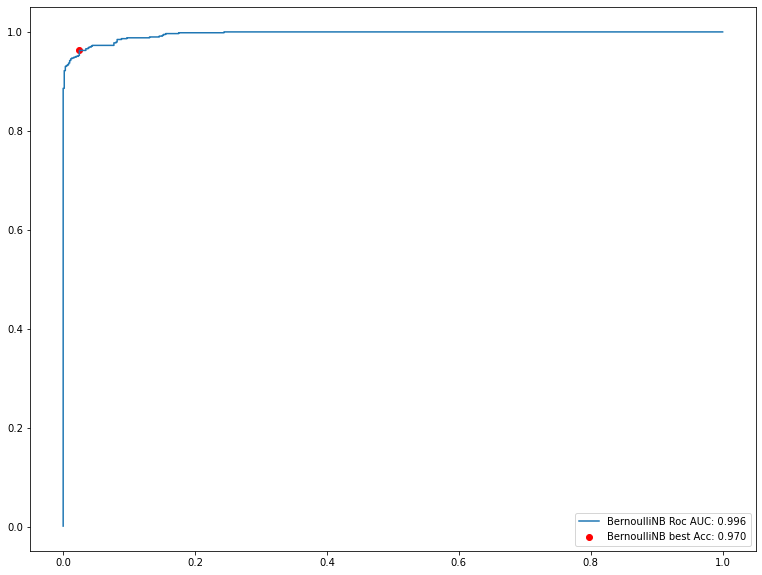

In [120]:
def peter_flack_roc(actual, predicted):
    n_samples = len(actual)
    pos = sum(actual)
    neg = len(actual)-pos
    data = np.c_[actual, predicted]
    data = np.flip(data[data[:, 1].argsort()], axis=-1)
    tpr,fpr,accs = list(),list(),list()
    tp,fp = 0,0
    x,y = 0,0
    for item in data[:,2].astype(int):
        if item:
            tp+=1
            y = tp/pos
        else:
            fp+=1
            x = fp/neg 
        
        tpr.append(y)
        fpr.append(x)
        accs.append((y*(pos/n_samples))+(neg/n_samples)-((pos/n_samples)*x))
    return (np.array(tpr), np.array(fpr), np.array(accs))

pern_proba =  bern_clf.predict_proba(X_test)
bern_tpr, bern_fpr, bern_accs= peter_flack_roc(y_test, pern_proba)

bern_auc = auc(bern_fpr,bern_tpr)
bern_best_acc = np.max(bern_accs)
bern_idx = np.argmax(bern_accs)
print(f'Best Accuracy: {bern_best_acc:.3f} at point ({bern_fpr[bern_idx]:.3f},{bern_tpr[bern_idx]:.3f})')

plt.figure(figsize=(13,10))
plt.plot(bern_fpr,bern_tpr, label=f'BernoulliNB Roc AUC: {bern_auc:.3f}')
plt.scatter(bern_fpr[bern_idx], bern_tpr[bern_idx], color='red', label=f'BernoulliNB best Acc: {bern_best_acc:.3f}')
plt.legend(loc='lower right')
plt.show()


## Multinomial NB

In [121]:
X_train, X_test, y_train, y_test = train_test_split(twitter_data, 
                                                    twitter_target, 
                                                    test_size=.1,
                                                    random_state=42)

multi_clf = MultinomialNB().fit(X_train, y_train)
multi_predictions = multi_clf.predict(X_test)
f1 = f1_score(y_test, multi_predictions)
accuracy = accuracy_score(y_test, multi_predictions)

print(f'F1 Score: {f1}, Accuracy Score: {accuracy_score}')


F1 Score: 0.9497942386831275, Accuracy Score: <function accuracy_score at 0x000002B5D5A421F0>


Best Accuracy: 0.968 at point (0.025,0.959)


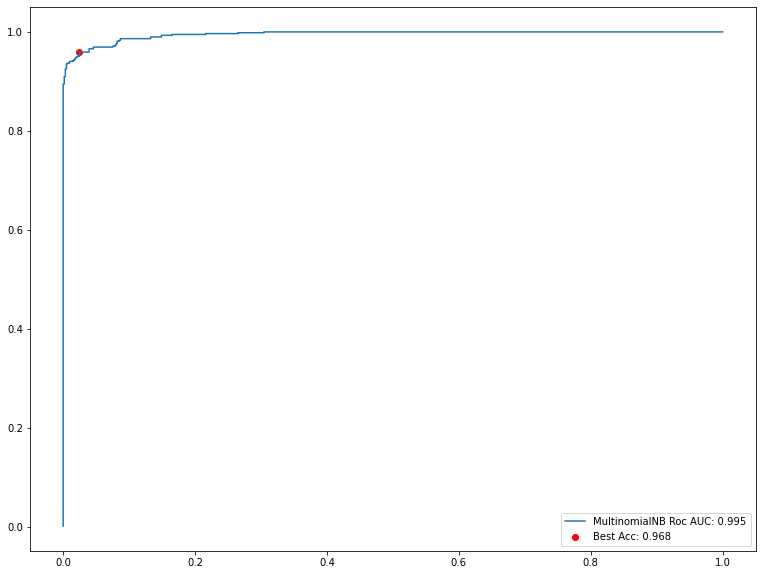

In [122]:
mult_proba =  multi_clf.predict_proba(X_test)
mult_tpr, mult_fpr, mult_accs = peter_flack_roc(y_test, mult_proba)

mult_auc = auc(mult_fpr, mult_tpr)
mult_best_acc = np.max(mult_accs)
mult_idx = np.argmax(mult_accs)
print(f'Best Accuracy: {mult_best_acc:.3f} at point ({mult_fpr[mult_idx]:.3f},{mult_tpr[mult_idx]:.3f})')

plt.figure(figsize=(13,10))
plt.plot(mult_fpr,mult_tpr, label=f'MultinomialNB Roc AUC: {mult_auc:.3f}')
plt.scatter(mult_fpr[mult_idx], mult_tpr[mult_idx], color='red', label=f'Best Acc: {mult_best_acc:.3f}')

plt.legend(loc='lower right')
plt.show()


## BernoulliNB Vs MultinomialNB

BernoulliNB > MultinomialNB in point: (0.025, 0.961), with accuracy: 0.969)
BernoulliNB > MultinomialNB in point: (0.025, 0.963), with accuracy: 0.970)
BernoulliNB > MultinomialNB in point: (0.026, 0.963), with accuracy: 0.969)
BernoulliNB > MultinomialNB in point: (0.028, 0.963), with accuracy: 0.968)


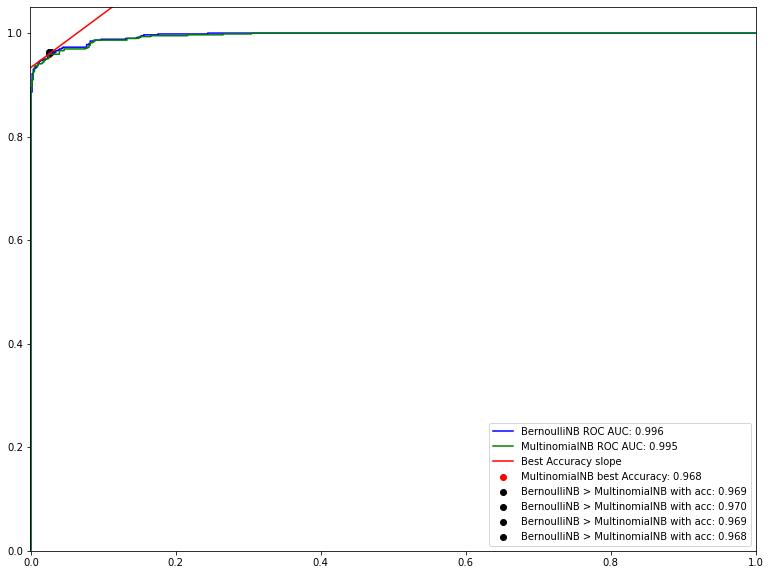

In [123]:

pos = sum(y_test)
neg = len(y_test) - pos
slope = neg/pos
x_sloped = np.linspace(0,1,100)
y_sloped = slope*(x_sloped - mult_fpr[mult_idx]) + mult_tpr[mult_idx]

plt.figure(figsize=(13,10))
plt.xlim([-0.001,1.0])
plt.ylim([0.0, 1.05])
plt.plot(bern_fpr, bern_tpr, color='blue', label=f'BernoulliNB ROC AUC: {bern_auc:.3f}')
plt.plot(mult_fpr, mult_tpr, color='green', label=f'MultinomialNB ROC AUC: {mult_auc:.3f}')
plt.plot(x_sloped, y_sloped, color='red', label=f'Best Accuracy slope')
plt.scatter(mult_fpr[mult_idx], mult_tpr[mult_idx], color='red', label=f'MultinomialNB best Accuracy: {mult_best_acc:.3f}')

points = np.array(np.where(bern_accs>mult_best_acc))

for j in points[0]:
    print(f'BernoulliNB > MultinomialNB in point: ({bern_fpr[j]:.3f}, {bern_tpr[j]:.3f}), with accuracy: {bern_accs[j]:.3f})')
    plt.scatter(bern_fpr[j], bern_tpr[j], color='black', label=f'BernoulliNB > MultinomialNB with acc: {bern_accs[j]:.3f}')
plt.legend(loc='lower right')

# Statistical test


Statistical test to determine whether observed differences are statistically significant between probabilistic classifiers on Multivariate and Multinomial texts

In [125]:
fold = 10

clf_bern = BernoulliNB()
scores_bnb = cross_val_score(clf_bern, twitter_data, twitter_target, cv=fold)
print('BernoulliNB:')
for i,v in enumerate(scores_bnb, start=1):
    print(f'Score fold {i}: {v}')

print(f'AVG Accuracy Score: {np.mean(scores_bnb):.3f} (+/- {np.std(scores_bnb):.3f})')

clf_mult = MultinomialNB()
scores_mult = cross_val_score(clf_mult, twitter_data, twitter_target, cv=fold)
print('MultinomialNB:')
for i,v in enumerate(scores_mult, start=1):
    print(f'Score fold {i}: {v}')

print(f'AVG Accuracy Score: {np.mean(scores_mult):.3f} (+/- {np.std(scores_mult):.3f})')

BernoulliNB:
Score fold 1: 0.9566305254378649
Score fold 2: 0.9657762938230384
Score fold 3: 0.9499165275459098
Score fold 4: 0.9499165275459098
Score fold 5: 0.9482470784641068
Score fold 6: 0.9524207011686143
Score fold 7: 0.9507512520868113
Score fold 8: 0.9549248747913188
Score fold 9: 0.9624373956594324
Score fold 10: 0.9365609348914858
AVG Accuracy Score: 0.953 (+/- 0.008)
MultinomialNB:
Score fold 1: 0.9541284403669725
Score fold 2: 0.9649415692821369
Score fold 3: 0.9499165275459098
Score fold 4: 0.9482470784641068
Score fold 5: 0.9440734557595993
Score fold 6: 0.9474123539232053
Score fold 7: 0.9490818030050083
Score fold 8: 0.9499165275459098
Score fold 9: 0.9616026711185309
Score fold 10: 0.9373956594323873
AVG Accuracy Score: 0.951 (+/- 0.008)


In [126]:
from scipy.stats import ttest_ind

t_statistic, p_value = ttest_ind(a=scores_bnb, b=scores_mult, axis=0)

alpha = 0.05

print(f'Alpha: {alpha:.3f}')
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value:.3f}')

if p_value > alpha:
    print('\nP-value >= Alpha ---> Same distribution (fail to reject H0)')
else:
    print('\nP-value <= Alpha ---> Different distribution (reject H0)')

Alpha: 0.050
T-statistic: 0.5809918432440697
P-value: 0.568

P-value >= Alpha ---> Same distribution (fail to reject H0)
